In [1]:
import torch
import torch.distributions as dist
import pandas as pd

# Precopute diffusion model with FEA. 
Using proxy for now.
In practice would discretize inputs and use lookup table for outputs

<Axes: >

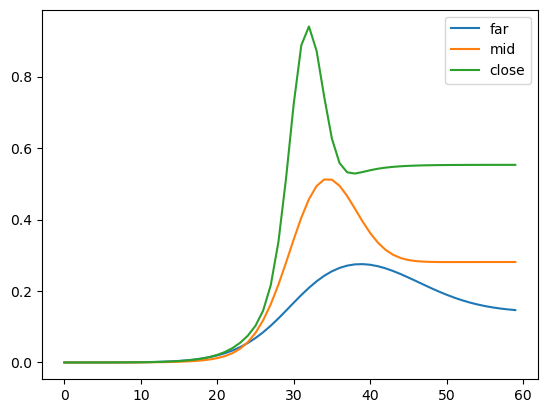

In [2]:
def precomputed_diffusion(R, sensor_location=torch.tensor([1,1])):
    mean = (R-sensor_location).norm()
    scale = (R-sensor_location).norm()
    n_points = 60
    theta_dummy = torch.linspace(-10,10,n_points)
    peak = dist.Normal(mean, scale).log_prob(theta_dummy).exp()
    baseline = peak.max()*torch.sigmoid(theta_dummy - (mean-1*scale))
    return peak + baseline

R = torch.tensor([-1, -1.0])
pd.Series(precomputed_diffusion(R)).plot(legend=True, label='far')

R = torch.tensor([0, 0.0])
pd.Series(precomputed_diffusion(R)).plot(legend=True, label='mid')

R = torch.tensor([0.5, 0.5])
pd.Series(precomputed_diffusion(R)).plot(legend=True, label='close')


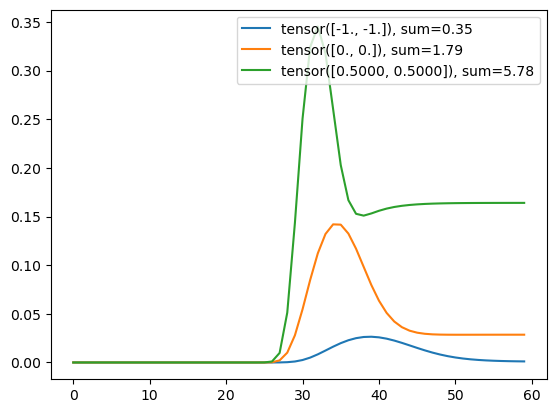

In [3]:
delta_u_over_kb = 1.0
for R in [torch.tensor([-1.0, -1]), torch.tensor([0, 0.0]), torch.tensor([0.5, 0.5])]:
    theta_i = precomputed_diffusion(R)
    Gamma = torch.exp(-delta_u_over_kb/theta_i)
    pd.Series(Gamma).plot(legend=True, label='{:}, sum={:1.2f}'.format(R, Gamma.sum()))

# The model

In [4]:
def physical_forward_model(observed_gamma=None):
    mu_theta_hot = 1
    sigma_theta_hot = 0.1

    theta_hot = dist.HalfNormal(mu_theta_hot, sigma_theta_hot).sample()

    epsilon_concentration, epsilon_rate = 10, 1
    epsilon = dist.Gamma(epsilon_concentration, epsilon_rate).sample()
    small_positive_number = torch.finfo(torch.float32).eps 
    theta_0 = theta_hot*dist.HalfNormal(small_positive_number,epsilon).sample()

    cov_00 = torch.eye(2)
    LG_00 = dist.MultivariateNormal(torch.zeros(2), cov_00)

    cov_11 = torch.tensor([[1, 0.5], [0.5, 1]])
    LG_01 = dist.MultivariateNormal(torch.tensor([0.5, 0.5]), cov_11)

    probe_distributions = [LG_00, LG_01]

    source_prior_params = torch.tensor([0.5, 0.5])
    if observed_gamma is not None:
        gamma = observed_gamma
    else:
        gamma = dist.Categorical(source_prior_params).sample()

    R = probe_distributions[gamma].sample()

    theta_i = theta_0 + precomputed_diffusion(R, sensor_location=torch.tensor([1,1]))

    delta_u_over_kb = 1
    Gamma = torch.exp(-delta_u_over_kb/theta_i).sum()
    rate = 1/Gamma
    d_switch = dist.Exponential(rate)
    trace = {
        'd_switch': d_switch,
        'gamma': gamma,
        # can return the whole trace here... in general objects will be different types and shapes... a dict is flexible enough to handle this
        }
    return trace




In [5]:
samples_given_gamma_observed_0 = []
samples_given_gamma_observed_1 = []
probs_given_0, probs_given_1 = [], []

n_samples = 1000

for idx in range(n_samples):
    trace_given_0 = physical_forward_model(observed_gamma=0)
    trace_given_1 = physical_forward_model(observed_gamma=1)

    d_given_0 = trace_given_0['d_switch']
    sample_from_d_given_0 = d_given_0.sample()

    d_given_1 = trace_given_1['d_switch']
    sample_from_d_given_1 = d_given_1.sample()

    samples_given_gamma_observed_0.append(sample_from_d_given_0.item())
    samples_given_gamma_observed_1.append(sample_from_d_given_1.item())

    probs_given_0.append(d_given_0.log_prob(sample_from_d_given_0).exp().item())
    probs_given_1.append(d_given_1.log_prob(sample_from_d_given_1).exp().item())

<Axes: ylabel='Frequency'>

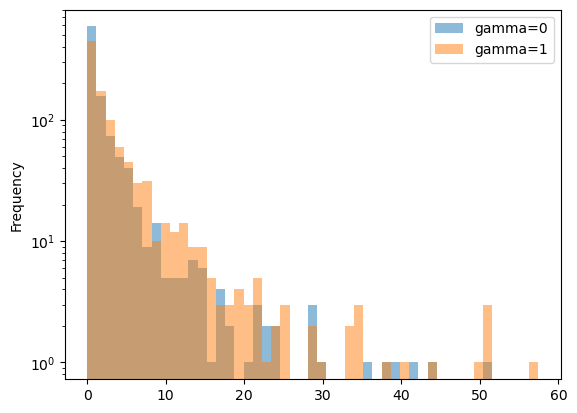

In [6]:
minimum = min(samples_given_gamma_observed_0 + samples_given_gamma_observed_1)
maximum = max(samples_given_gamma_observed_0 + samples_given_gamma_observed_1)

bins = torch.linspace(minimum, maximum, 50)

logy = True
pd.Series(samples_given_gamma_observed_0).plot.hist(bins=bins, alpha=0.5, legend=True, label='gamma=0', logy=logy)
pd.Series(samples_given_gamma_observed_1).plot.hist(bins=bins, alpha=0.5, legend=True, label='gamma=1', logy=logy)

# ABC

Given we have some observed time, we can use as an ABC distance criaterion how close our modelled time is to the sampled time.

```d(observed t_switch, modelled t_switch) < epsilon```

If the agreement is "close enough" up to the resolution of our stop watch, then we use this to accumulate our posterior

In [7]:
n_samples = 10000
t_observed = 20.0
gamma_accepted = []
eps_stop_watch = 3
for idx in range(n_samples):
    trace = physical_forward_model()
    t_switch = trace['d_switch'].sample()
    if (t_switch - t_observed).abs() < eps_stop_watch:
        gamma_accepted.append(trace['gamma'].item())


<Axes: >

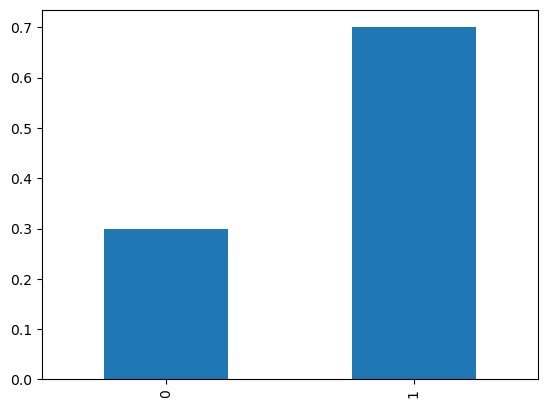

In [8]:
sr = (pd.Series(gamma_accepted).value_counts() / len(gamma_accepted))
sr.sort_index(inplace=True)
sr.plot.bar()

We can get error bars on these estimates by running inference multiple times...

In [9]:
n_inference_rounds = 10
n_samples = 1000
t_observed = 20.0
normalized_counts = []
for idx in range(n_inference_rounds):

    gamma_accepted = []
    eps_stop_watch = 3
    for idx in range(n_samples):
        trace = physical_forward_model()
        t_switch = trace['d_switch'].sample()
        if (t_switch - t_observed).abs() < eps_stop_watch:
            gamma_accepted.append(trace['gamma'].item())
    sr = pd.Series(gamma_accepted).value_counts() / len(gamma_accepted)
    normalized_counts.append(sr.to_dict())


<Axes: >

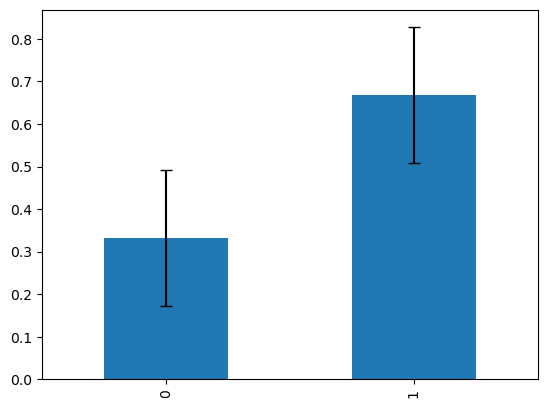

In [10]:
df = pd.concat([pd.DataFrame(normalized_counts).mean(), pd.DataFrame(normalized_counts).std()], axis=1)
df.columns=['normalized_counts', 'errors']
df.sort_index(inplace=True)
df['normalized_counts'].plot.bar(yerr=df['errors'], capsize=4)  # capsize specifies the width of the error caps


This is a per-measurement posterior. There are other techniques to estimate the source distribution given many independent measurements of `t_switch`.

# Importance sampling
* https://en.wikipedia.org/wiki/Importance_sampling

In ABC we through out a lot of simulations and only take a bin around the area we are interested in.

However, our probabilistic simulator gives us the ability to evaluate the probability for any event, no matter how rare, and to use this information in weighting it later on.

Here we use a very basic technique called importance sampling.

In [11]:
## SAME AS BEFORE
# n_inference_rounds = 10
# n_samples = 1000
# t_observed = 20.0

normalized_prob_weights = []

for idx in range(n_inference_rounds): # this outer loop is to showcase how IS gets smaller error bars that ABC.

    gammas = []
    probs = []
    for idx in range(n_samples):
        trace = physical_forward_model()
        gammas.append(trace['gamma'].item())
        observe_prob = trace['d_switch'].log_prob(torch.tensor(t_observed)).exp() 
            # this is the important part where we use the density, which will be different for each trace, and evalute the probability, which we will normalize later after all the samplig is done.
        probs.append(observe_prob.item())

    # now we normalize the probabilities, and weight gamma by the "importance" of the trace
    df = pd.DataFrame({'gammas':gammas, 'probs':probs})
    df['normalized_prob_weights'] = df['probs']/df['probs'].sum()
    normalized_prob_weights.append(df.groupby('gammas')['normalized_prob_weights'].sum().to_dict())



<Axes: >

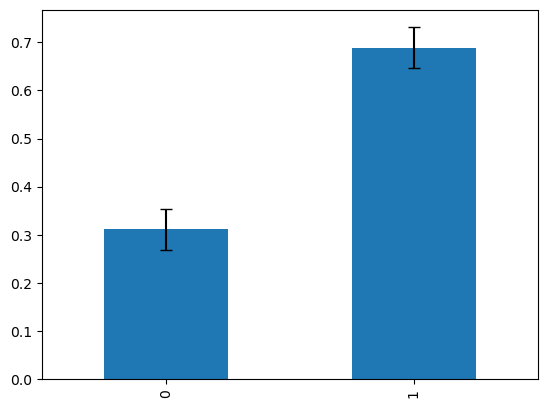

In [12]:
df = pd.concat([pd.DataFrame(normalized_prob_weights).mean(), pd.DataFrame(normalized_prob_weights).std()], axis=1)
df.columns=['normalized_prob_weights', 'errors']
df.sort_index(inplace=True)
df['normalized_prob_weights'].plot.bar(yerr=df['errors'], capsize=4)  # capsize specifies the width of the error caps


The error bars are smaller since we are using the information of each sample, and weighting it accordingly. 